In [40]:
! pip install pyspark

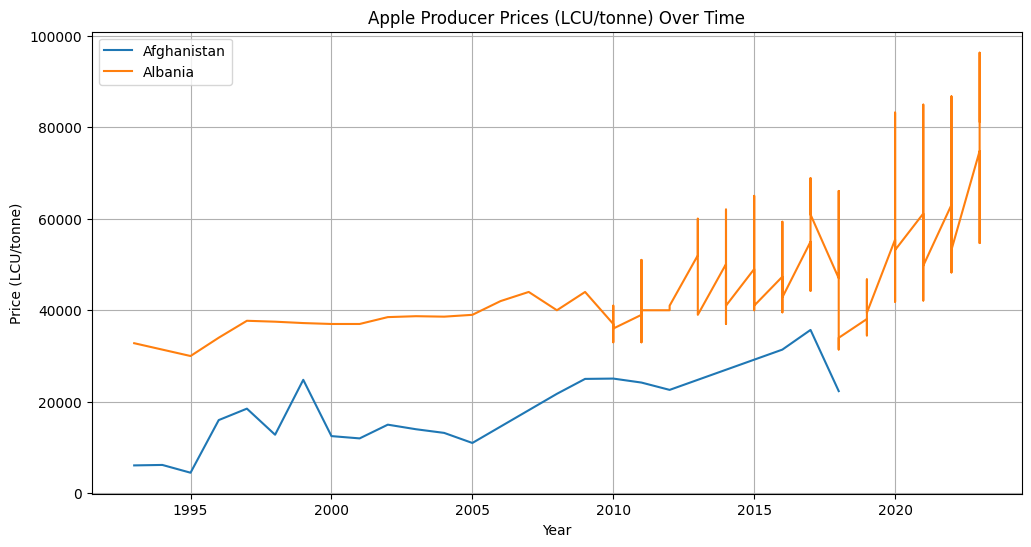

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/Prices_E_All_Data.csv', encoding='latin1')

# Filter for Apples data
apples = df[(df['Item'] == 'Apples') & (df['Element'] == 'Producer Price (LCU/tonne)')]

# Select relevant columns (years)
years = [f'Y{year}' for year in range(1991, 2025)]
apples = apples[['Area', *years]]

# Melt to long format for easier plotting
apples_melted = apples.melt(id_vars='Area', var_name='Year', value_name='Price')
apples_melted['Year'] = apples_melted['Year'].str[1:].astype(int)

# Filter for Afghanistan and Albania
countries = ['Afghanistan', 'Albania']
apples_filtered = apples_melted[apples_melted['Area'].isin(countries)].dropna()

# Plot
plt.figure(figsize=(12, 6))
for country in countries:
    country_data = apples_filtered[apples_filtered['Area'] == country]
    plt.plot(country_data['Year'], country_data['Price'], label=country)

plt.title('Apple Producer Prices (LCU/tonne) Over Time')
plt.xlabel('Year')
plt.ylabel('Price (LCU/tonne)')
plt.legend()
plt.grid(True)
plt.show()

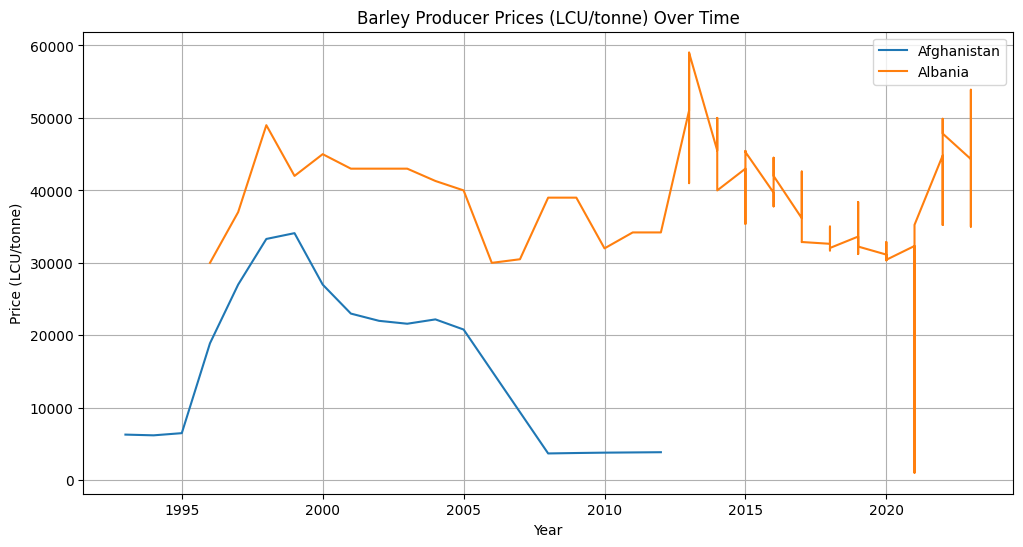

In [3]:
# Filter for Barley data
barley = df[(df['Item'] == 'Barley') & (df['Element'] == 'Producer Price (LCU/tonne)')]

# Select relevant columns
barley = barley[['Area', *years]]

# Melt to long format
barley_melted = barley.melt(id_vars='Area', var_name='Year', value_name='Price')
barley_melted['Year'] = barley_melted['Year'].str[1:].astype(int)

# Filter for our countries
barley_filtered = barley_melted[barley_melted['Area'].isin(countries)].dropna()

# Plot
plt.figure(figsize=(12, 6))
for country in countries:
    country_data = barley_filtered[barley_filtered['Area'] == country]
    plt.plot(country_data['Year'], country_data['Price'], label=country)

plt.title('Barley Producer Prices (LCU/tonne) Over Time')
plt.xlabel('Year')
plt.ylabel('Price (LCU/tonne)')
plt.legend()
plt.grid(True)
plt.show()

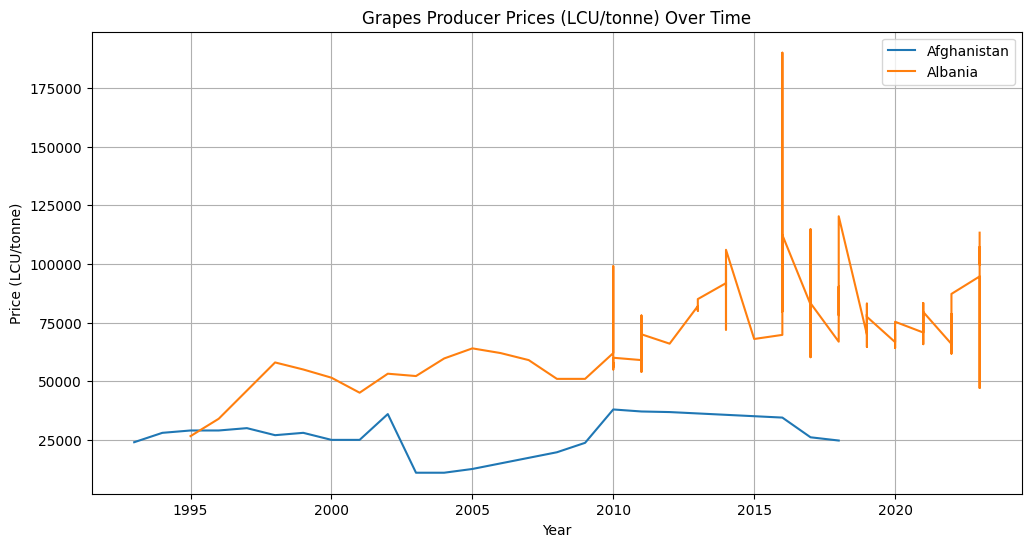

In [4]:
# Filter for Grapes data
grapes = df[(df['Item'] == 'Grapes') & (df['Element'] == 'Producer Price (LCU/tonne)')]

# Select relevant columns
grapes = grapes[['Area', *years]]

# Melt to long format
grapes_melted = grapes.melt(id_vars='Area', var_name='Year', value_name='Price')
grapes_melted['Year'] = grapes_melted['Year'].str[1:].astype(int)

# Filter for our countries
grapes_filtered = grapes_melted[grapes_melted['Area'].isin(countries)].dropna()

# Plot
plt.figure(figsize=(12, 6))
for country in countries:
    country_data = grapes_filtered[grapes_filtered['Area'] == country]
    plt.plot(country_data['Year'], country_data['Price'], label=country)

plt.title('Grapes Producer Prices (LCU/tonne) Over Time')
plt.xlabel('Year')
plt.ylabel('Price (LCU/tonne)')
plt.legend()
plt.grid(True)
plt.show()

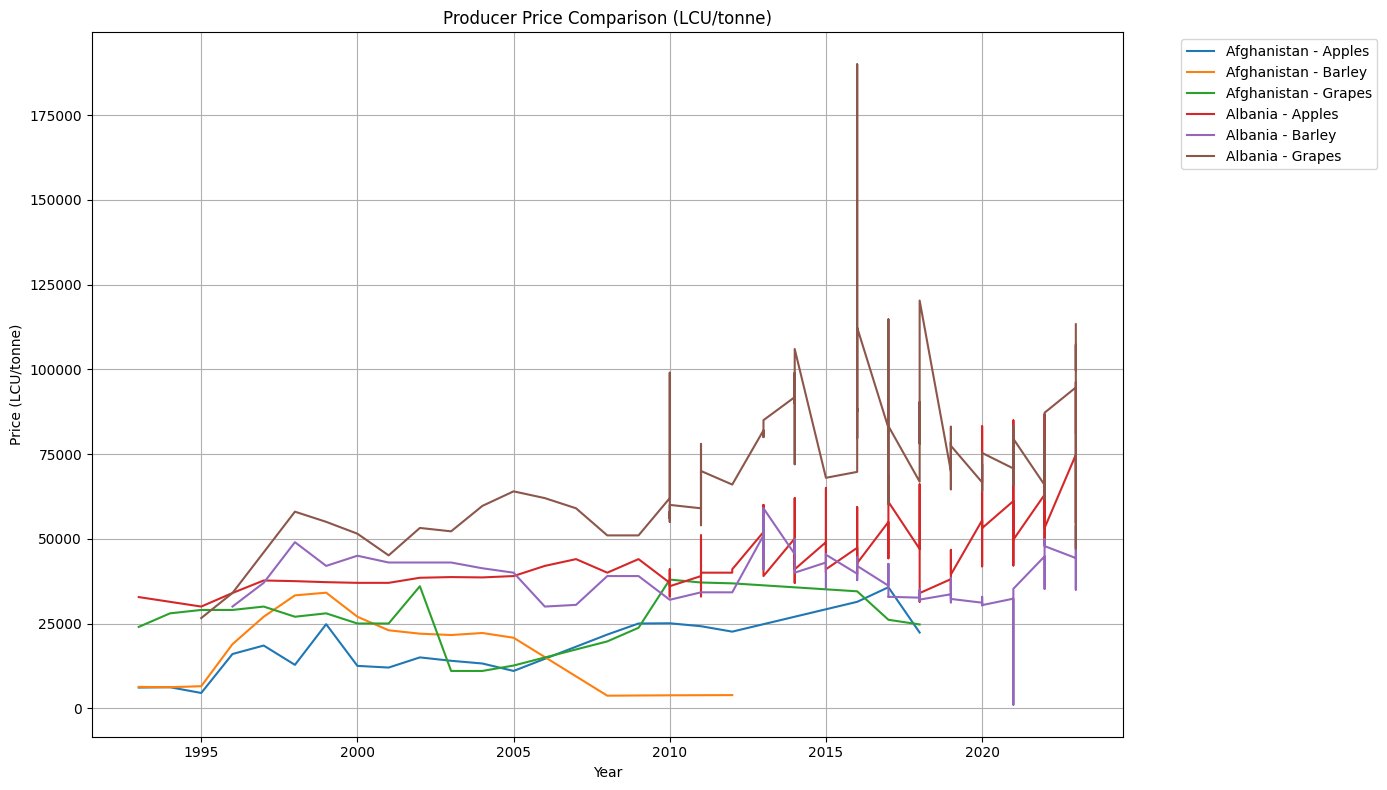

In [5]:
# Combine all three crops for comparison
combined = pd.concat([
    apples_filtered.assign(Crop='Apples'),
    barley_filtered.assign(Crop='Barley'),
    grapes_filtered.assign(Crop='Grapes')
])

# Plot
plt.figure(figsize=(14, 8))
for country in countries:
    for crop in ['Apples', 'Barley', 'Grapes']:
        subset = combined[(combined['Area'] == country) & (combined['Crop'] == crop)]
        plt.plot(subset['Year'], subset['Price'], label=f'{country} - {crop}')

plt.title('Producer Price Comparison (LCU/tonne)')
plt.xlabel('Year')
plt.ylabel('Price (LCU/tonne)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

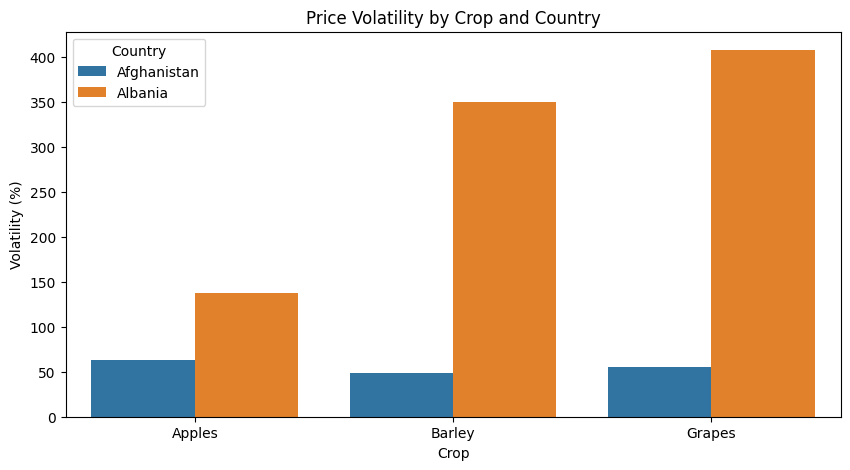

In [9]:
import numpy as np

# Function to calculate volatility (standard deviation of annual price changes)
def calculate_volatility(df, country, crop):
    crop_data = df[(df['Area'] == country) & (df['Item'] == crop) &
                  (df['Element'] == 'Producer Price (LCU/tonne)')]
    if crop_data.empty:
        return np.nan

    # Convert prices to numeric, handling errors
    prices = pd.to_numeric(crop_data.iloc[:, 6:].values.flatten(), errors='coerce')

    prices = prices[~pd.isna(prices)]  # Remove NaN
    annual_changes = np.diff(prices) / prices[:-1]  # Yearly % change
    return np.std(annual_changes) * 100  # Volatility as %

# Compare volatility for selected crops
# ... (rest of the code remains the same)
# Compare volatility for selected crops
crops = ['Apples', 'Barley', 'Grapes']
volatility_data = []
for country in ['Afghanistan', 'Albania']:
    for crop in crops:
        vol = calculate_volatility(df, country, crop)
        volatility_data.append({'Country': country, 'Crop': crop, 'Volatility (%)': vol})

volatility_df = pd.DataFrame(volatility_data).dropna()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=volatility_df, x='Crop', y='Volatility (%)', hue='Country')
plt.title('Price Volatility by Crop and Country')
plt.show()

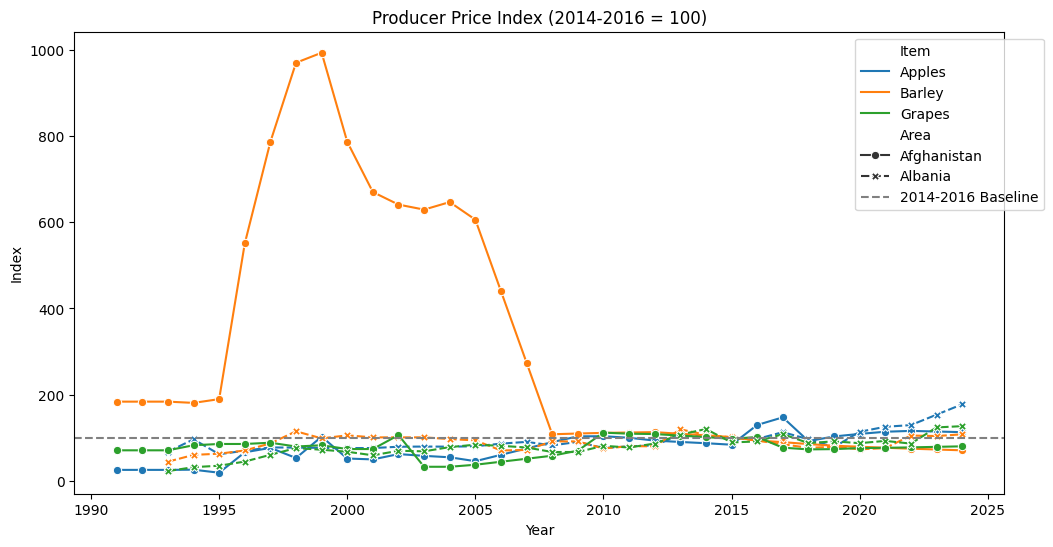

In [8]:
# Filter for PPI (Producer Price Index) data
ppi_data = df[df['Element'] == 'Producer Price Index (2014-2016 = 100)']

# Select countries and crops
selected = ppi_data[ppi_data['Item'].isin(['Apples', 'Barley', 'Grapes']) &
                   ppi_data['Area'].isin(['Afghanistan', 'Albania'])]

# Melt and clean
ppi_melted = selected.melt(id_vars=['Area', 'Item'], value_vars=years, var_name='Year', value_name='Index')
ppi_melted['Year'] = ppi_melted['Year'].str[1:].astype(int)
ppi_melted = ppi_melted.dropna()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=ppi_melted, x='Year', y='Index', hue='Item', style='Area', markers=True)
plt.axhline(100, linestyle='--', color='gray', label='2014-2016 Baseline')
plt.title('Producer Price Index (2014-2016 = 100)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

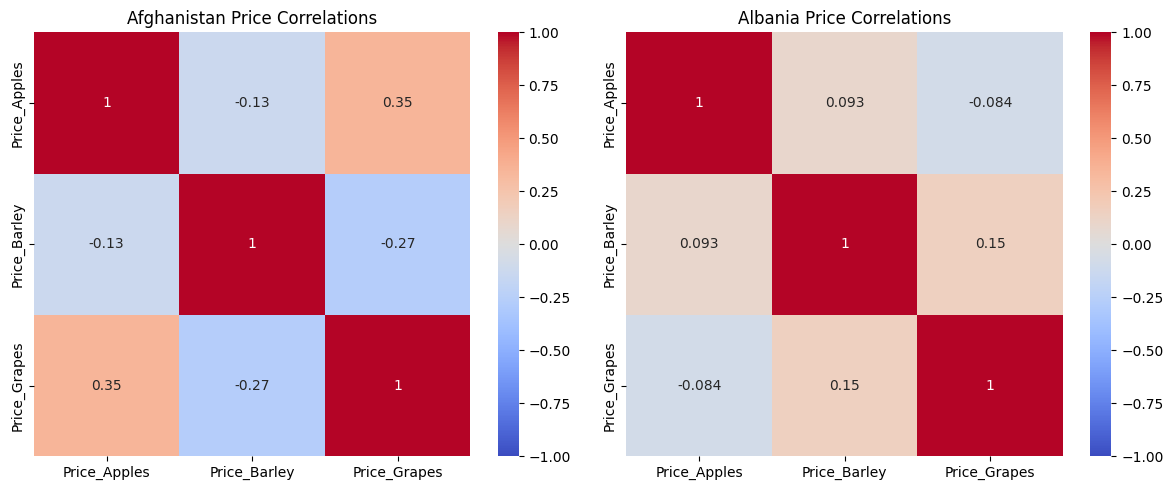

In [10]:
# Pivot to get crops as columns
pivot_prices = apples_filtered.merge(
    barley_filtered, on=['Area', 'Year'], suffixes=('_Apples', '_Barley')
).merge(
    grapes_filtered, on=['Area', 'Year']
).rename(columns={'Price': 'Price_Grapes'})

# Calculate correlation matrix
corr_afg = pivot_prices[pivot_prices['Area'] == 'Afghanistan'][['Price_Apples', 'Price_Barley', 'Price_Grapes']].corr()
corr_alb = pivot_prices[pivot_prices['Area'] == 'Albania'][['Price_Apples', 'Price_Barley', 'Price_Grapes']].corr()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_afg, annot=True, cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Afghanistan Price Correlations')
sns.heatmap(corr_alb, annot=True, cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('Albania Price Correlations')
plt.tight_layout()
plt.show()

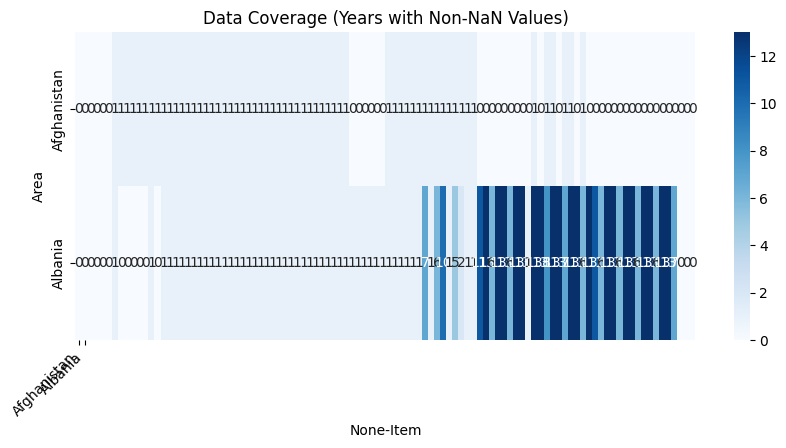

In [16]:
# Count non-NaN values per crop/country
coverage = df[df['Element'] == 'Producer Price (LCU/tonne)'].groupby(
    ['Area', 'Item']
)[years].count().unstack(level=1).fillna(0) # Unstack with level=1 to get countries as columns

# Access columns using a tuple for multi-index
# Changed: Accessing columns using correct levels
# Changed: Accessing rows using correct level values (countries) and columns using crop names
#selected_coverage = coverage.loc[coverage.index.get_level_values(1).isin(crops), countries]
#selected_coverage = coverage.loc[coverage.index.isin(countries)][crops]
# Corrected line: Select rows with countries and columns with crops
selected_coverage = coverage.loc[countries, (slice(None), crops)] # slice(None) selects all levels in the first level (years)

# Plot missing data for selected crops
plt.figure(figsize=(10, 4))
# Set xticklabels rotation for better readability
sns.heatmap(selected_coverage, annot=True, fmt='.0f', cmap='Blues', xticklabels=countries)
plt.title('Data Coverage (Years with Non-NaN Values)')
plt.xticks(rotation=45, ha='right') # Rotate xticklabels for better readability
plt.show()

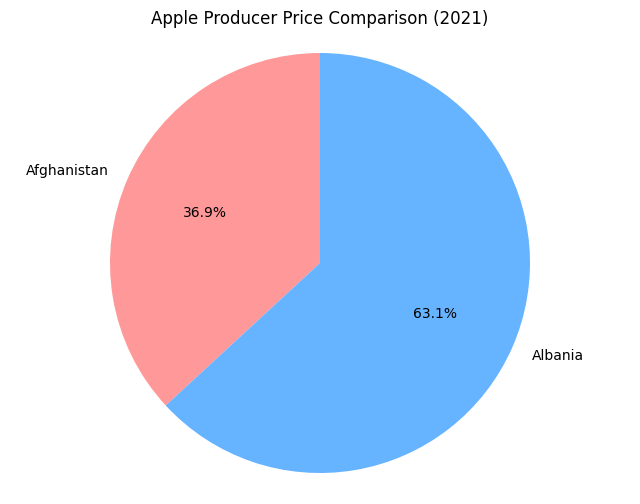

In [27]:
import matplotlib.pyplot as plt

# Data
countries = ['Afghanistan', 'Albania']
prices = [35700, 61126.2]
colors = ['#ff9999','#66b3ff']

# Plot
plt.figure(figsize=(8,6))
plt.pie(prices, labels=countries, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Apple Producer Price Comparison (2021)')
plt.axis('equal')
plt.show()

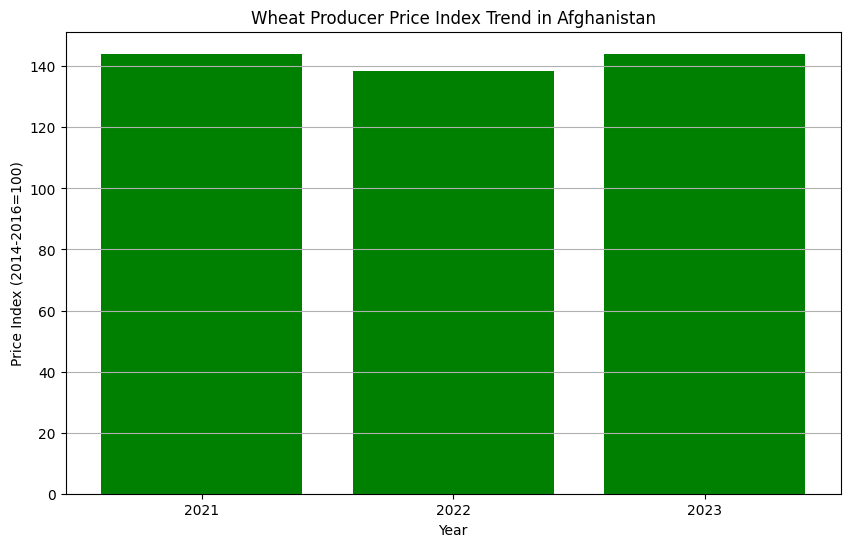

In [28]:
import matplotlib.pyplot as plt

# Data
years = [2021, 2022, 2023]
price_index = [144.11, 138.49, 144.11]

# Plot
plt.figure(figsize=(10,6))
plt.bar(years, price_index, color='green')
plt.xlabel('Year')
plt.ylabel('Price Index (2014-2016=100)')
plt.title('Wheat Producer Price Index Trend in Afghanistan')
plt.xticks(years)
plt.grid(axis='y')
plt.show()

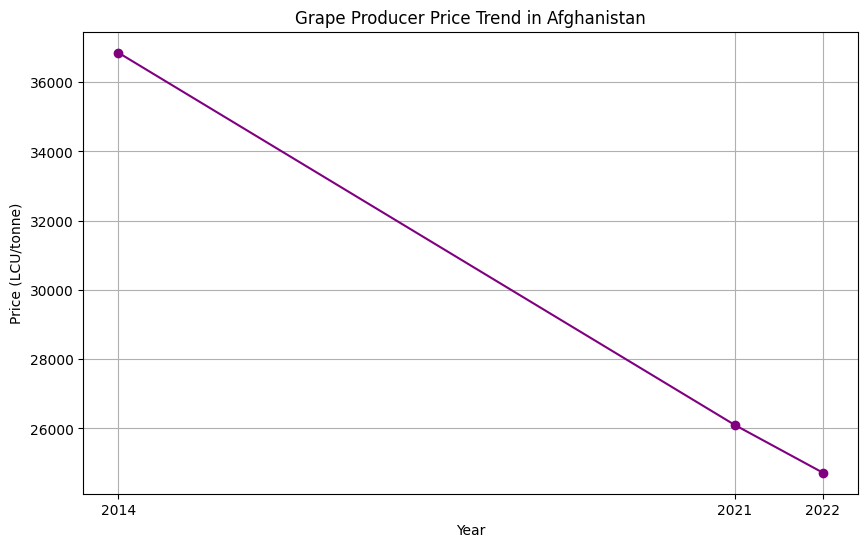

In [29]:
import matplotlib.pyplot as plt

# Data
years = [2014, 2021, 2022]
prices = [36850, 26100, 24721.8]

# Plot
plt.figure(figsize=(10,6))
plt.plot(years, prices, marker='o', color='purple')
plt.xlabel('Year')
plt.ylabel('Price (LCU/tonne)')
plt.title('Grape Producer Price Trend in Afghanistan')
plt.xticks(years)
plt.grid()
plt.show()

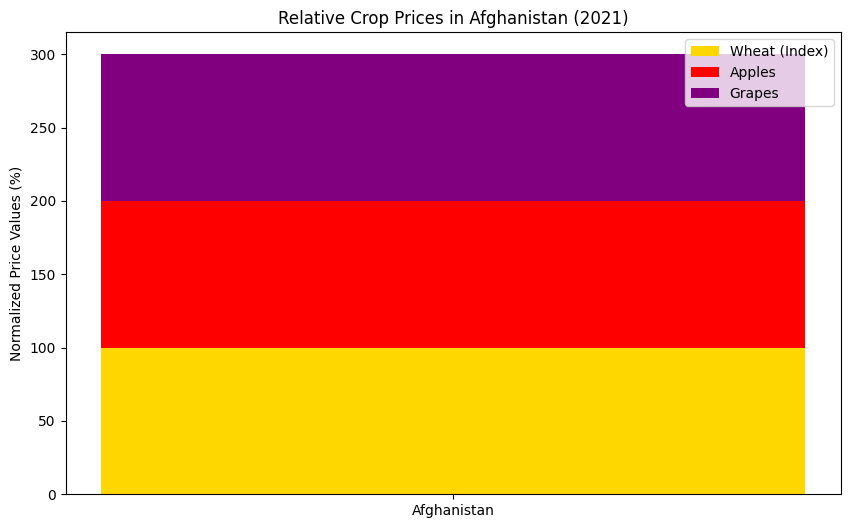

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Data
countries = ['Afghanistan']
wheat = [144.11]  # using index values
apples = [35700]  # using LCU values
grapes = [36850]   # using LCU values

# Normalize for comparison
norm_wheat = [x/max(wheat)*100 for x in wheat]
norm_apples = [x/max(apples)*100 for x in apples]
norm_grapes = [x/max(grapes)*100 for x in grapes]

# Plot
plt.figure(figsize=(10,6))
plt.bar(countries, norm_wheat, color='gold', label='Wheat (Index)')
plt.bar(countries, norm_apples, bottom=norm_wheat, color='red', label='Apples')
plt.bar(countries, norm_grapes, bottom=[i+j for i,j in zip(norm_wheat, norm_apples)],
        color='purple', label='Grapes')
plt.ylabel('Normalized Price Values (%)')
plt.title('Relative Crop Prices in Afghanistan (2021)')
plt.legend()
plt.show()

In [22]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


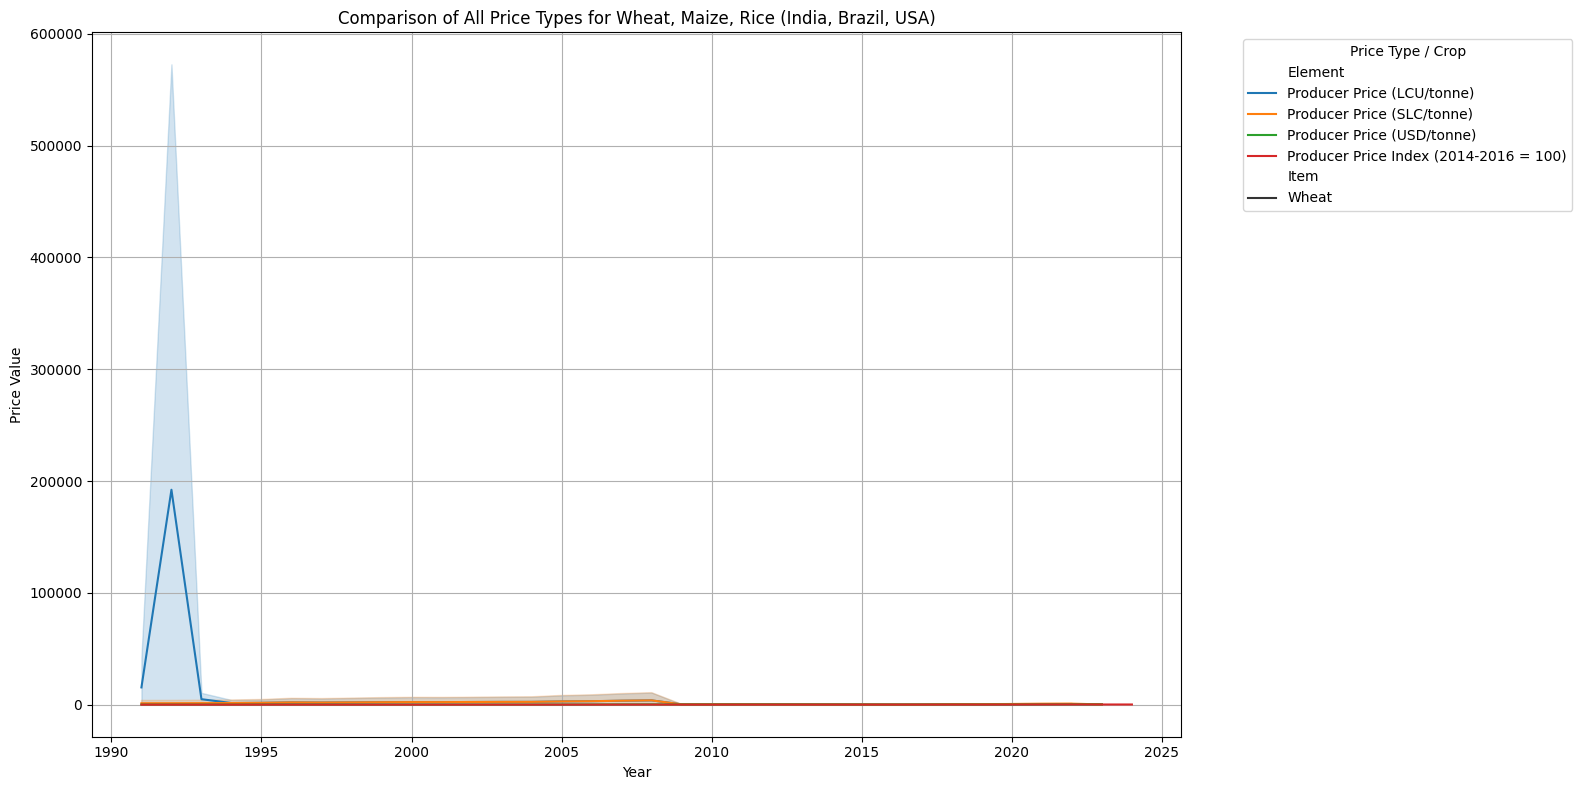

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Initialize Spark session
spark = SparkSession.builder \
    .appName("InteractiveCropPricePrediction") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Prices_E_All_Data.csv", header=True, inferSchema=True)

# Get unique countries and crops
countries = [row['Area'] for row in df.select('Area').distinct().collect()]
crops = [row['Item'] for row in df.select('Item').distinct().collect()]

# Create dropdown widgets
country_dropdown = Dropdown(
    options=countries,
    value='Afghanistan',
    description='Country:',
    disabled=False
)

crop_dropdown = Dropdown(
    options=crops,
    value='Wheat',
    description='Crop:',
    disabled=False
)

# Function to process data and make predictions
def analyze_crop_prices(country, crop):
    # Filter data for selected country and crop
    df_filtered = df.filter(
        (df.Area == country) &
        (df.Item == crop) &
        (df.Element == "Producer Price (LCU/tonne)")
    )

    if df_filtered.count() == 0:
        print(f"No data available for {crop} in {country}")
        return

    # Melt the dataframe to convert years from columns to rows
    years = [col for col in df_filtered.columns if col.startswith('Y') and not col.endswith('F')]
    other_cols = [col for col in df_filtered.columns if not col.startswith('Y')]

    exploded_dfs = []
    for year_col in years:
        year = year_col[1:]  # Extract year from column name
        temp_df = df_filtered.select(
            *other_cols,
            col(year_col).alias("Value"),
            when(col(year_col).isNotNull(), int(year)).alias("Year")
        )
        exploded_dfs.append(temp_df)

    # Union all the exploded dataframes
    df_long = exploded_dfs[0]
    for temp_df in exploded_dfs[1:]:
        df_long = df_long.union(temp_df)

    # Filter out null values and convert Value to double
    df_long = df_long.filter(df_long.Value.isNotNull())
    df_long = df_long.withColumn("Value", df_long.Value.cast(DoubleType()))

    # Create time series features
    df_ts = df_long.withColumn("Year", df_long.Year.cast("integer"))
    df_ts = df_ts.withColumn("Year_squared", col("Year") ** 2)
    df_ts = df_ts.withColumn("Year_cubed", col("Year") ** 3)

    # Split data into training and test sets (last 5 years for testing)
    train_df = df_ts.filter(col("Year") <= 2017)
    test_df = df_ts.filter(col("Year") > 2017)

    if train_df.count() == 0 or test_df.count() == 0:
        print("Not enough data for training and testing")
        return

    # Prepare feature vector
    assembler = VectorAssembler(
        inputCols=["Year", "Year_squared", "Year_cubed"],
        outputCol="features"
    )

    # Models to try
    rf = RandomForestRegressor(featuresCol="features", labelCol="Value", numTrees=100)
    gbt = GBTRegressor(featuresCol="features", labelCol="Value", maxIter=100)

    # Create pipelines
    rf_pipeline = Pipeline(stages=[assembler, rf])
    gbt_pipeline = Pipeline(stages=[assembler, gbt])

    # Train models
    rf_model = rf_pipeline.fit(train_df)
    gbt_model = gbt_pipeline.fit(train_df)

    # Make predictions
    rf_predictions = rf_model.transform(test_df)
    gbt_predictions = gbt_model.transform(test_df)

    # Evaluate models
    evaluator = RegressionEvaluator(labelCol="Value", predictionCol="prediction", metricName="rmse")
    rf_rmse = evaluator.evaluate(rf_predictions)
    gbt_rmse = evaluator.evaluate(gbt_predictions)

    # Select the better model
    if rf_rmse < gbt_rmse:
        best_model = rf_model
        model_type = "Random Forest"
        best_rmse = rf_rmse
    else:
        best_model = gbt_model
        model_type = "Gradient Boosted Trees"
        best_rmse = gbt_rmse

    print(f"\nAnalysis for {crop} in {country}:")
    print(f"Best model: {model_type} with RMSE: {best_rmse:.2f}")

    # Create future years data for prediction (next 5 years)
    max_year = df_ts.select("Year").agg({"Year": "max"}).collect()[0][0]
    future_years = [max_year + i for i in range(1, 6)]

    future_data = spark.createDataFrame(
        [(crop, year, year**2, year**3) for year in future_years],
        ["Item", "Year", "Year_squared", "Year_cubed"]
    )

    # Make future predictions
    future_predictions = best_model.transform(future_data)

    # Collect results
    results = future_predictions.select("Year", "prediction").collect()

    # Convert to pandas for visualization
    history_pd = df_long.toPandas()
    future_pd = future_predictions.select("Year", "prediction").toPandas()

    # Plot historical data and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(history_pd["Year"], history_pd["Value"], 'b-', label='Historical Data')
    plt.plot(future_pd["Year"], future_pd["prediction"], 'r--', label='Predicted Future')
    plt.title(f'Price Prediction for {crop} in {country}')
    plt.xlabel('Year')
    plt.ylabel('Price (LCU/tonne)')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Print future predictions
    print("\nFuture price predictions:")
    for row in results:
        print(f"Year {row.Year}: {row.prediction:.2f} LCU/tonne")

# Create interactive widget
interact(analyze_crop_prices, country=country_dropdown, crop=crop_dropdown)

# Note: In a Jupyter Notebook, you don't need to stop the Spark session immediately
# spark.stop()

interactive(children=(Dropdown(description='Country:', index=12, options=("Côte d'Ivoire", 'Chad', 'Ethiopia P…

<function __main__.analyze_crop_prices(country, crop)>

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown
import numpy as np
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, lag

# Initialize Spark session
spark = SparkSession.builder \
    .appName("InteractiveCropPricePrediction") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Prices_E_All_Data.csv", header=True, inferSchema=True)

# Get unique countries and crops
countries = [row['Area'] for row in df.select('Area').distinct().collect()]
crops = [row['Item'] for row in df.select('Item').distinct().collect()]

# Create dropdown widgets
country_dropdown = Dropdown(
    options=countries,
    value='Afghanistan',
    description='Country:',
    disabled=False
)

crop_dropdown = Dropdown(
    options=crops,
    value='Wheat',
    description='Crop:',
    disabled=False
)

def analyze_crop_prices(country, crop):
    # Filter data for selected country and crop
    df_filtered = df.filter(
        (df.Area == country) &
        (df.Item == crop) &
        (df.Element == "Producer Price (LCU/tonne)")
    )

    if df_filtered.count() == 0:
        print(f"No data available for {crop} in {country}")
        return

    # Melt the dataframe to convert years from columns to rows
    years = [col for col in df_filtered.columns if col.startswith('Y') and not col.endswith('F')]
    other_cols = [col for col in df_filtered.columns if not col.startswith('Y')]

    exploded_dfs = []
    for year_col in years:
        year = year_col[1:]  # Extract year from column name
        temp_df = df_filtered.select(
            *other_cols,
            col(year_col).alias("Value"),
            when(col(year_col).isNotNull(), int(year)).alias("Year")
        )
        exploded_dfs.append(temp_df)

    # Union all the exploded dataframes
    df_long = exploded_dfs[0]
    for temp_df in exploded_dfs[1:]:
        df_long = df_long.union(temp_df)

    # Filter out null values and convert Value to double
    df_long = df_long.filter(df_long.Value.isNotNull())
    df_long = df_long.withColumn("Value", df_long.Value.cast(DoubleType()))

    # Create time series features
    df_ts = df_long.withColumn("Year", df_long.Year.cast("integer"))
    df_ts = df_ts.withColumn("Year_squared", col("Year") ** 2)
    df_ts = df_ts.withColumn("Year_cubed", col("Year") ** 3)
    df_ts = df_ts.withColumn("Moving_avg_3",
                           when(col("Year") >= 3,
                                avg(col("Value")).over(Window.orderBy("Year").rowsBetween(-2, 0))))
    df_ts = df_ts.withColumn("Moving_avg_5",
                           when(col("Year") >= 5,
                                avg(col("Value")).over(Window.orderBy("Year").rowsBetween(-4, 0))))
    df_ts = df_ts.withColumn("Price_change",
                           when(col("Year") > min_year,
                                col("Value") - lag(col("Value"), 1).over(Window.orderBy("Year"))))
    df_ts = df_ts.withColumn("Price_pct_change",
                           when(col("Year") > min_year,
                                (col("Value") - lag(col("Value"), 1).over(Window.orderBy("Year"))) /
                                lag(col("Value"), 1).over(Window.orderBy("Year")) * 100))

    # Split data into training and test sets (last 5 years for testing)
    train_df = df_ts.filter(col("Year") <= 2017)
    test_df = df_ts.filter(col("Year") > 2017)

    if train_df.count() == 0 or test_df.count() == 0:
        print("Not enough data for training and testing")
        return

    # Prepare feature vector with all features
    feature_cols = ["Year", "Year_squared", "Year_cubed", "Moving_avg_3", "Moving_avg_5",
                   "Price_change", "Price_pct_change"]
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features"
    )

    # Models to try
    rf = RandomForestRegressor(featuresCol="features", labelCol="Value", numTrees=100)
    gbt = GBTRegressor(featuresCol="features", labelCol="Value", maxIter=100)

    # Create pipelines
    rf_pipeline = Pipeline(stages=[assembler, rf])
    gbt_pipeline = Pipeline(stages=[assembler, gbt])

    # Train models
    rf_model = rf_pipeline.fit(train_df)
    gbt_model = gbt_pipeline.fit(train_df)

    # Make predictions
    rf_predictions = rf_model.transform(test_df)
    gbt_predictions = gbt_model.transform(test_df)

    # Evaluate models
    evaluator = RegressionEvaluator(labelCol="Value", predictionCol="prediction", metricName="rmse")
    rf_rmse = evaluator.evaluate(rf_predictions)
    gbt_rmse = evaluator.evaluate(gbt_predictions)

    # Select the better model
    if rf_rmse < gbt_rmse:
        best_model = rf_model
        model_type = "Random Forest"
        best_rmse = rf_rmse

        # Get feature importances
        feature_importances = best_model.stages[-1].featureImportances
        importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': [feature_importances[i] for i in range(len(feature_cols))]
        })
    else:
        best_model = gbt_model
        model_type = "Gradient Boosted Trees"
        best_rmse = gbt_rmse

        # Get feature importances
        feature_importances = best_model.stages[-1].featureImportances
        importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': [feature_importances[i] for i in range(len(feature_cols))]
        })

    print(f"\nAnalysis for {crop} in {country}:")
    print(f"Best model: {model_type} with RMSE: {best_rmse:.2f}")

    # Sort features by importance and get top 7
    importance_df = importance_df.sort_values('Importance', ascending=False).head(7)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Top 7 Features for {crop} Price Prediction in {country}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    # Create future years data for prediction (next 5 years)
    max_year = df_ts.select("Year").agg({"Year": "max"}).collect()[0][0]
    future_years = [max_year + i for i in range(1, 6)]

    # Calculate moving averages and price changes for future predictions
    # We'll need to create these features based on historical data
    last_values = df_ts.orderBy("Year", ascending=False).limit(5).collect()
    last_3_avg = np.mean([row.Value for row in last_values[:3]])
    last_5_avg = np.mean([row.Value for row in last_values])
    last_price = last_values[0].Value

    future_data = []
    for i, year in enumerate(future_years):
        # For each future year, we'll need to update the moving averages and price changes
        # This is a simplified approach - in a real scenario you might want a more sophisticated method
        future_moving_avg_3 = last_3_avg if i < 3 else None
        future_moving_avg_5 = last_5_avg if i < 5 else None
        future_price_change = None  # Can't calculate for future without predictions
        future_pct_change = None

        future_data.append([crop, year, year**2, year**3,
                          future_moving_avg_3, future_moving_avg_5,
                          future_price_change, future_pct_change])

    future_df = spark.createDataFrame(
        future_data,
        ["Item", "Year", "Year_squared", "Year_cubed",
         "Moving_avg_3", "Moving_avg_5", "Price_change", "Price_pct_change"]
    )

    # Make future predictions
    future_predictions = best_model.transform(future_df)

    # Collect results
    results = future_predictions.select("Year", "prediction").collect()

    # Convert to pandas for visualization
    history_pd = df_long.toPandas()
    future_pd = future_predictions.select("Year", "prediction").toPandas()

    # Plot historical data and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(history_pd["Year"], history_pd["Value"], 'b-', label='Historical Data')
    plt.plot(future_pd["Year"], future_pd["prediction"], 'r--', label='Predicted Future')
    plt.title(f'Price Prediction for {crop} in {country}')
    plt.xlabel('Year')
    plt.ylabel('Price (LCU/tonne)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print future predictions
    print("\nFuture price predictions:")
    for row in results:
        print(f"Year {row.Year}: {row.prediction:.2f} LCU/tonne")

# Create interactive widget
interact(analyze_crop_prices, country=country_dropdown, crop=crop_dropdown)

interactive(children=(Dropdown(description='Country:', index=12, options=("Côte d'Ivoire", 'Chad', 'Ethiopia P…

<function __main__.analyze_crop_prices(country, crop)>

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown

# Initialize Spark session
spark = SparkSession.builder \
    .appName("InteractiveCropPricePrediction") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/Prices_E_All_Data.csv", header=True, inferSchema=True)

# Get unique countries and crops
countries = [row['Area'] for row in df.select('Area').distinct().collect()]
crops = [row['Item'] for row in df.select('Item').distinct().collect()]

# Create dropdown widgets
country_dropdown = Dropdown(
    options=countries,
    value='Afghanistan',
    description='Country:',
    disabled=False
)

crop_dropdown = Dropdown(
    options=crops,
    value='Wheat',
    description='Crop:',
    disabled=False
)

def plot_feature_importance(model, feature_names):
    """Plot feature importance for tree-based models"""
    if hasattr(model.stages[-1], 'featureImportances'):
        importances = model.stages[-1].featureImportances
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': [importances[i] for i in range(len(feature_names))]
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 5))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title('Feature Importance')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.show()
    else:
        print("Feature importance not available for this model type")

def analyze_crop_prices(country, crop):
    # Filter data for selected country and crop
    df_filtered = df.filter(
        (df.Area == country) &
        (df.Item == crop) &
        (df.Element == "Producer Price (LCU/tonne)")
    )

    if df_filtered.count() == 0:
        print(f"No data available for {crop} in {country}")
        return

    # Melt the dataframe to convert years from columns to rows
    years = [col for col in df_filtered.columns if col.startswith('Y') and not col.endswith('F')]
    other_cols = [col for col in df_filtered.columns if not col.startswith('Y')]

    exploded_dfs = []
    for year_col in years:
        year = year_col[1:]  # Extract year from column name
        temp_df = df_filtered.select(
            *other_cols,
            col(year_col).alias("Value"),
            when(col(year_col).isNotNull(), int(year)).alias("Year")
        )
        exploded_dfs.append(temp_df)

    # Union all the exploded dataframes
    df_long = exploded_dfs[0]
    for temp_df in exploded_dfs[1:]:
        df_long = df_long.union(temp_df)

    # Filter out null values and convert Value to double
    df_long = df_long.filter(df_long.Value.isNotNull())
    df_long = df_long.withColumn("Value", df_long.Value.cast(DoubleType()))

    # Create time series features
    df_ts = df_long.withColumn("Year", df_long.Year.cast("integer"))
    df_ts = df_ts.withColumn("Year_squared", col("Year") ** 2)
    df_ts = df_ts.withColumn("Year_cubed", col("Year") ** 3)

    # Split data into training and test sets (last 5 years for testing)
    train_df = df_ts.filter(col("Year") <= 2017)
    test_df = df_ts.filter(col("Year") > 2017)

    if train_df.count() == 0 or test_df.count() == 0:
        print("Not enough data for training and testing")
        return

    # Prepare feature vector
    feature_cols = ["Year", "Year_squared", "Year_cubed"]
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features"
    )

    # Models to try
    rf = RandomForestRegressor(featuresCol="features", labelCol="Value", numTrees=100)
    gbt = GBTRegressor(featuresCol="features", labelCol="Value", maxIter=100)

    # Create pipelines
    rf_pipeline = Pipeline(stages=[assembler, rf])
    gbt_pipeline = Pipeline(stages=[assembler, gbt])

    # Train models
    rf_model = rf_pipeline.fit(train_df)
    gbt_model = gbt_pipeline.fit(train_df)

    # Make predictions
    rf_predictions = rf_model.transform(test_df)
    gbt_predictions = gbt_model.transform(test_df)

    # Evaluate models
    evaluator = RegressionEvaluator(labelCol="Value", predictionCol="prediction", metricName="rmse")
    rf_rmse = evaluator.evaluate(rf_predictions)
    gbt_rmse = evaluator.evaluate(gbt_predictions)

    # Select the better model
    if rf_rmse < gbt_rmse:
        best_model = rf_model
        model_type = "Random Forest"
        best_rmse = rf_rmse
    else:
        best_model = gbt_model
        model_type = "Gradient Boosted Trees"
        best_rmse = gbt_rmse

    print(f"\nAnalysis for {crop} in {country}:")
    print(f"Best model: {model_type} with RMSE: {best_rmse:.2f}")

    # Visualize feature importance
    print("\nFeature Importance Analysis:")
    plot_feature_importance(best_model, feature_cols)

    # Create future years data for prediction (next 5 years)
    max_year = df_ts.select("Year").agg({"Year": "max"}).collect()[0][0]
    future_years = [max_year + i for i in range(1, 6)]

    future_data = spark.createDataFrame(
        [(crop, year, year**2, year**3) for year in future_years],
        ["Item", "Year", "Year_squared", "Year_cubed"]
    )

    # Make future predictions
    future_predictions = best_model.transform(future_data)

    # Collect results
    results = future_predictions.select("Year", "prediction").collect()

    # Convert to pandas for visualization
    history_pd = df_long.toPandas()
    future_pd = future_predictions.select("Year", "prediction").toPandas()

    # Plot historical data and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(history_pd["Year"], history_pd["Value"], 'b-', label='Historical Data')
    plt.plot(future_pd["Year"], future_pd["prediction"], 'r--', label='Predicted Future')
    plt.title(f'Price Prediction for {crop} in {country}')
    plt.xlabel('Year')
    plt.ylabel('Price (LCU/tonne)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot feature relationships
    print("\nFeature Relationships:")
    plt.figure(figsize=(15, 5))

    # Plot Year vs Value
    plt.subplot(1, 3, 1)
    sns.scatterplot(x='Year', y='Value', data=history_pd)
    plt.title('Year vs Price')
    plt.xlabel('Year')
    plt.ylabel('Price (LCU/tonne)')

    # Plot Year_squared vs Value
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=history_pd['Year']**2, y='Value', data=history_pd)
    plt.title('Year² vs Price')
    plt.xlabel('Year Squared')
    plt.ylabel('Price (LCU/tonne)')

    # Plot Year_cubed vs Value
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=history_pd['Year']**3, y='Value', data=history_pd)
    plt.title('Year³ vs Price')
    plt.xlabel('Year Cubed')
    plt.ylabel('Price (LCU/tonne)')

    plt.tight_layout()
    plt.show()

    # Print future predictions
    print("\nFuture price predictions:")
    for row in results:
        print(f"Year {row.Year}: {row.prediction:.2f} LCU/tonne")

# Create interactive widget
interact(analyze_crop_prices, country=country_dropdown, crop=crop_dropdown)

interactive(children=(Dropdown(description='Country:', index=12, options=("Côte d'Ivoire", 'Chad', 'Ethiopia P…

<function __main__.analyze_crop_prices(country, crop)>